# barotropic tides with FES

In [1]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

from scipy import signal

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs

import pytide

#import mitequinox.utils as ut
#import mitequinox.plot as pl
#import mitequinox.sigp as sp

In [2]:
fes_dir = "/home/datawork-lops-osi/equinox/misc/tides/FES2014"

---

## look at data files directly

In [47]:
files = glob(os.path.join(fes_dir, "fes2014_elevations_and_load/fes2014b_elevations/ocean_tide/*.nc"))
csts0 = [f.split("/")[-1].split(".")[0] for f in files]

# align cases with pytide
pytide_csts = [c for c in pytide.WaveTable.known_constituents()]
csts_mapping = {}
for c in csts0:
    for _c in pytide_csts:
        if c.lower()==_c.lower():
            csts_mapping[c] = _c
    # manual adjustment
    if c=="la2":
        print("Guess la2 is Lambda2, need to be checked")
        csts_mapping[c] = "Lambda2"

Guess la2 is Lambda2, need to be checked


In [72]:
ds = (xr.concat([xr.open_dataset(f) for f in files], "constituent")
      .assign_coords(constituent=list(csts_mapping.values()))
     )

# add frequencies
wt = pytide.WaveTable(ds.constituent.values)
ds = ds.assign_coords(frequency = ("constituent", wt.freq()))
ds = ds.assign_coords(frequency_cpd = ds.frequency*86400/2/np.pi )
ds = ds.sortby("frequency")

ds

<xarray.Dataset>
Dimensions:      (constituent: 34, lat: 2881, lon: 5760, nv: 2)
Coordinates:
  * lat          (lat) float32 -90.0 -89.94 -89.88 -89.81 ... 89.88 89.94 90.0
  * lon          (lon) float32 0.0 0.0625 0.125 0.1875 ... 359.8 359.9 359.9
  * nv           (nv) int32 0 1
  * constituent  (constituent) <U7 'Sa' 'Ssa' 'Mm' 'MSf' ... 'S4' 'M6' 'M8'
    frequency    (constituent) float64 1.991e-07 3.982e-07 ... 0.0005621
Data variables:
    lat_bnds     (constituent, lat, nv) float32 -89.97 -90.03 ... 90.03 89.97
    lon_bnds     (constituent, lon, nv) float32 -0.03125 0.03125 ... 359.9 360.0
    crs          (constituent) int32 -2147483647 -2147483647 ... -2147483647
    phase        (constituent, lat, lon) float32 nan nan nan nan ... nan nan nan
    amplitude    (constituent, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes: (12/16)
    cdm_data_type:              Grid
    license:                    http://www.aviso.oceanobs.com/fileadmin/docum...
    title:                      FES2014b tide elevations
    product_version:            b
    summary:                    global tide solution using finite element mes...
    project:                    FES2014
    ...                         ...
    history:                    2016-10-20 12:39:17:creation
    Conventions:                CF-1.6
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    geospatial_lat_resolution:  0.0625
    geospatial_lon_resolution:  0.0625

In [76]:
# compute mean amplitude
mean = ds.amplitude.mean(["lon", "lat"]).compute()
mean

<xarray.DataArray 'amplitude' (constituent: 34)>
array([4.9752486e-03, 7.5111181e-01, 8.1427324e-01, 3.3244584e-02,
       1.4211576e+00, 2.5734276e-01, 2.4025451e-02, 1.8896605e+00,
       8.8611708e+00, 3.7370949e+00, 4.2131594e-01, 1.1774960e+01,
       7.5186723e-01, 2.9204807e-01, 9.5372653e-01, 1.0939077e+00,
       6.4970274e+00, 1.2889445e+00, 3.0316423e+01, 7.0593208e-02,
       2.7105540e-01, 8.4725559e-01, 7.0611894e-01, 1.2073801e+01,
       9.9601232e-02, 3.4320855e+00, 3.2613393e-02, 3.6136445e-02,
       1.8523432e-01, 3.0756301e-01, 1.8837583e-01, 1.1162691e-01,
       2.1493216e-01, 1.1581183e-02], dtype=float32)
Coordinates:
  * constituent    (constituent) <U7 'Sa' 'Ssa' 'Mm' 'MSf' ... 'S4' 'M6' 'M8'
    frequency      (constituent) float64 1.991e-07 3.982e-07 ... 0.0005621
    frequency_cpd  (constituent) float64 0.002738 0.005476 ... 5.797 7.729

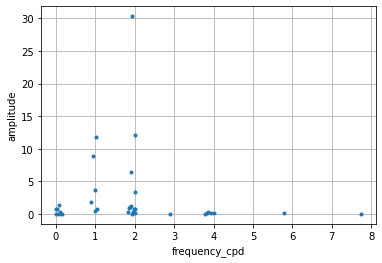

In [87]:
hdl = mean.plot(x="frequency_cpd", lw=0, marker=".")
hdl[0].axes.grid()

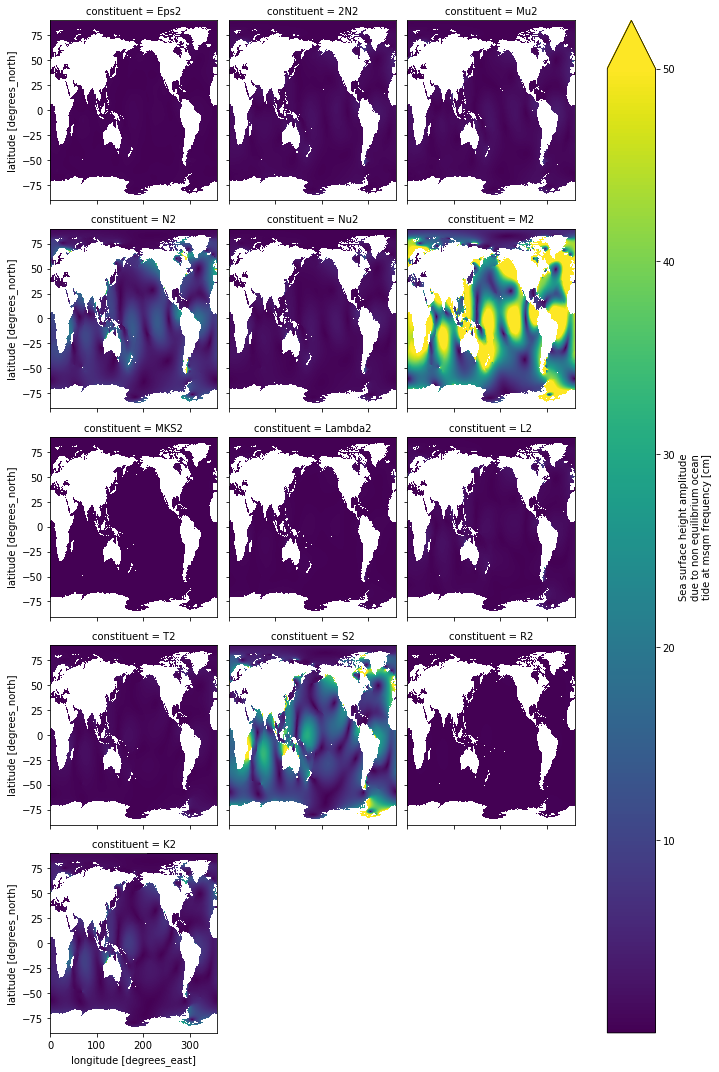

In [92]:
# semidiurnal constituents
_ds = (ds.where( (ds.frequency_cpd>1.5 ) &  (ds.frequency_cpd<2.5 ) , drop=True)
       .isel(lon=slice(0,None, 4), lat=slice(0, None, 4))
      )

_ds.amplitude.plot(x="lon", y="lat", col="constituent", col_wrap=3, vmax=50)


--- 

## pyfes

https://bitbucket.org/cnes_aviso/fes/issues/3/advice-on-installing-python-package


In [11]:
import pyfes

ImportError: libnetcdf.so.15: cannot open shared object file: No such file or directory

In [10]:
ini_dir = os.path.join(fes_dir, "code/fes/data/fes2014/")
config_ocean = os.path.join(ini_dir, "ocean_tide.ini")
config_load = os.path.join(ini_dir, "load_tide.ini")

In [ ]:
import datetime
config_ocean = r"H:\Downloads\fes-2.9.1-Source\data\fes2014\ocean_tide.ini"
ocean_tide = pyfes.Handler("ocean", "io", config_ocean)
config_load = r"H:\Downloads\fes-2.9.1-Source\data\fes2014\load_tide.ini"
load_tide = pyfes.Handler("radial", "io", config_load)
dates_np = np.empty((len(dates),), dtype='datetime64[us]')
for i,date in enumerate(dates):
    dates_np[i] = datetime(date.year,date.month,date.day,date.hour,date.minute,date.second)
lons = Tidelatlon[0]*np.ones(len(dates))
lats = Tidelatlon[1]*np.ones(len(dates))
# compute heights for ocean tide and loadings
ocean_short, ocean_long, min_points = ocean_tide.calculate(lons, lats, dates_np)
load_short, load_long, min_points = load_tide.calculate(lons, lats, dates_np)
# sum up all components and convert from cm to m
tide_level = (ocean_short + ocean_long + load_short + load_long)/100
# tide level contains the predicted tide heights in m
